In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle

In [2]:
!pip install chardet

In [3]:
import chardet

In [4]:
with open('/content/spam.csv', 'rb') as f:
    encoding = chardet.detect(f.read())['encoding']

In [5]:
encoding

'Windows-1252'

In [6]:
df = pd.read_csv('/content/spam.csv', encoding=encoding)
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [7]:
df = df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])

In [8]:
df.shape

(5572, 2)

In [9]:
df.columns

Index(['v1', 'v2'], dtype='object')

In [10]:
df.rename(columns={"v1": "Category", "v2": "Message"}, inplace=True)

In [11]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Data Cleaning

In [13]:
df.isna().sum().to_frame(name='# of missing values')

,# of missing values
Category,0
Message,0


In [14]:
total_rows =  df.shape[0]
df.dropna(how='any',inplace=True)
remaining_rows= df.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)



No. of rows removed : 0


I could not use stop worlds,PorterStemmer,lemmatization,Punctuation remove becase these also make sense to detect as Spam or not spam message


WORD CLOUD

In [15]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

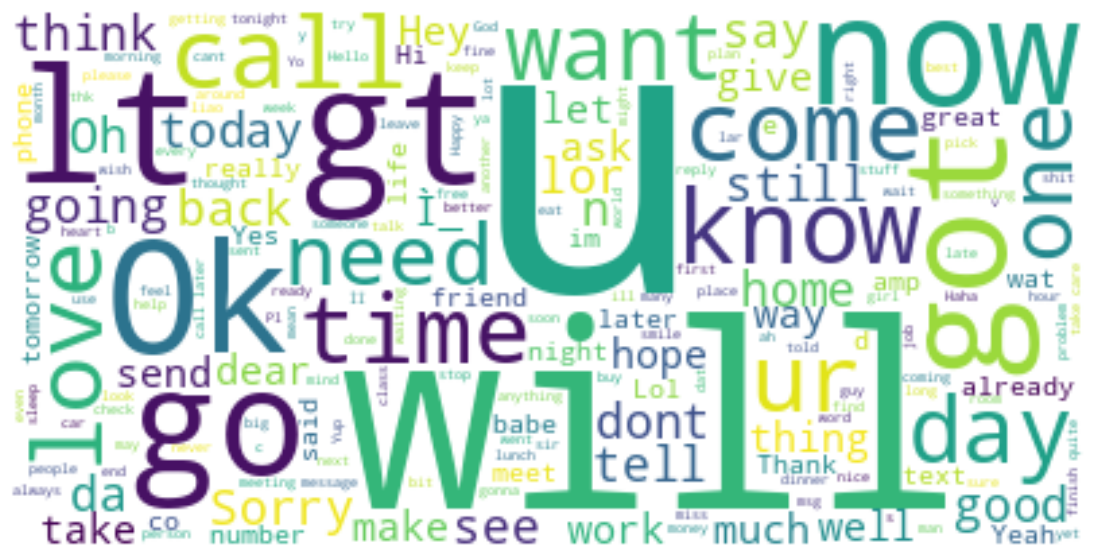

In [16]:
pos = df.loc[df.Category  =="ham"].Message
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

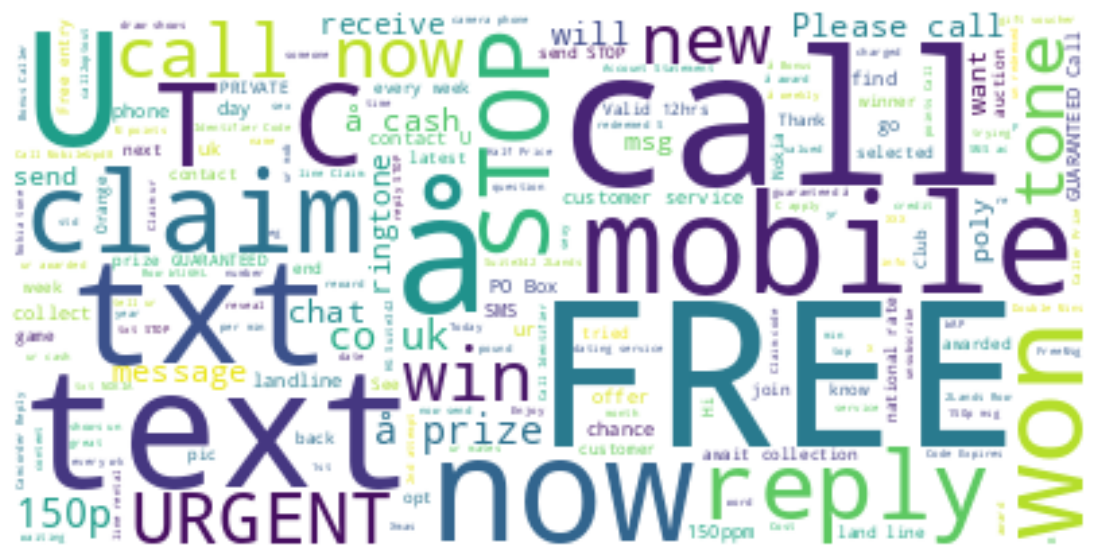

In [17]:
pos = df.loc[df.Category  =="spam"].Message
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

Label Encoding


In [18]:
df['Spam']=df['Category'].apply(lambda x:1 if x=='spam' else 0)
df.head()

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Train Test Split

In [19]:
from sklearn.model_selection import train_test_split
X = df.Message
y = df.Category

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.20, random_state=1, stratify=y)

In [20]:
X_train.shape, X_test.shape



((4457,), (1115,))

Vectorization


BOW Vectorization

In [21]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

TF-IDF

In [22]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

MODEL TRAINING

In [23]:
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

Logistic Regression with BoW

In [24]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.8658290329818263
Test accuracy score : 0.8663677130044843

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.9443571909356069
Test accuracy score : 0.9363228699551569

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.9840700022436617
Test accuracy score : 0.9721973094170404

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.9984294368409243
Test accuracy score : 0.9802690582959641

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 1.0
Test accuracy score : 0.9811659192825112

 ----------------------------------------


Naive Bayes Classifier With Bow

In [25]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.9975319721785955
Test accuracy score : 0.9811659192825112

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.9959614090195199
Test accuracy score : 0.989237668161435

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.9939421135292797
Test accuracy score : 0.989237668161435

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.9939421135292797
Test accuracy score : 0.9883408071748879

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.9934933811981154
Test accuracy score : 0.9883408071748879

 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


Logistic Regression with Tf-Idf

In [26]:
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.8658290329818263
Test accuracy score : 0.8663677130044843

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.8658290329818263
Test accuracy score : 0.8663677130044843

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.8671752299753197
Test accuracy score : 0.8699551569506726

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.9750953556203724
Test accuracy score : 0.9704035874439462

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.9984294368409243
Test accuracy score : 0.9856502242152466

 ----------------------------------------


Naive Bayes classifier with Tf-Idf

In [27]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.9997756338344178
Test accuracy score : 0.979372197309417

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.9961857751851021
Test accuracy score : 0.9811659192825112

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.9854161992371551
Test accuracy score : 0.9730941704035875

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.9798070450975993
Test accuracy score : 0.9659192825112107

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.9735247924612969
Test accuracy score : 0.9650224215246637

 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


The Differnce between Train and test accuracy MultinomialNB(alpha=1)TF-IDF is less than others so we choose this as best model

In [28]:
Best_Model=MultinomialNB(alpha=1)
Best_Model.fit(tfidf_X_train, y_train)

MultinomialNB(alpha=1)

In [29]:
MultinomialNB(alpha=1)

MultinomialNB(alpha=1)

In [30]:
y_preds_train = Best_Model.predict(tfidf_X_train)
y_preds_test = Best_Model.predict(tfidf_X_test)

In [31]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.9735247924612969
Test accuracy score : 0.9650224215246637
